In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from omegaconf import OmegaConf
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('csv_data/mutation.csv')
df2 = pd.read_csv('csv_data/no_mutation.csv')

#df1 = pd.read_csv('feature_vectors_mut.csv')
#df2 = pd.read_csv('feature_vectors_nomut.csv')

df1['mutation'] = 1
df2['mutation'] = 0

df = pd.concat([df1, df2])

In [11]:
diagnostic_features = OmegaConf.load('config.yaml').exclude_features
df_test = pd.read_csv('csv_data/OVER700_anonym.csv')
df_test = df_test.drop(diagnostic_features, axis=1)
df_test = df_test.drop(['name', 'mutation'], axis=1)

In [12]:
#Удалим столбец с именем
df = df.drop('filename', axis=1)

KeyError: "['filename'] not found in axis"

In [13]:
#Выведем столбцы не float64 и не int64
for i in df.columns:
    if df[i].dtype != 'float64' and df[i].dtype != 'int64':
        print(i)
        

In [14]:
# Разделение данных на признаки и целевую переменную
X = df.drop(columns=['mutation'])
y = df['mutation']

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

#Сохраним датасет в файл
df_sm = pd.DataFrame(X_sm)
df_sm['mutation'] = y_sm

C:\Users\kungu\AppData\Local\Temp\ipykernel_2976\4231542167.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sm['mutation'] = y_sm


# No modifications

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

cv_scores_rec = cross_val_score(clf, X, y, cv=5, scoring='recall')
cv_scores_acc = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

print("Cross-validation score:")
print('Recall:', np.mean(cv_scores_rec), 'Accuracy:', np.mean(cv_scores_acc))
print('Predictions on over 700 data:', predictions := clf.predict(df_test), 'Accuracy', accuracy_score(predictions, np.zeros_like(predictions)))

Cross-validation score:
Recall: 0.8307692307692308 Accuracy: 0.6398692810457516
Predictions on over 700 data: [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0
 1 1 1 1 1 0 0 1 1] Accuracy 0.1956521739130435


# With smote

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np

X_sm = df_sm.drop(columns=['mutation'])
y_sm = df_sm['mutation']

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.4, random_state=42, stratify=y_sm)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

cv_scores_rec = cross_val_score(clf, X_sm, y_sm, cv=5, scoring='recall')
cv_scores_acc = cross_val_score(clf, X_sm, y_sm, cv=5, scoring='accuracy')

print("Cross-validation score:")
print('Recall:', np.mean(cv_scores_rec), 'Accuracy:', np.mean(cv_scores_acc))
print('Predictions on over 700 data:', predictions := clf.predict(df_test), 'Accuracy', accuracy_score(predictions, np.zeros_like(predictions)))

Cross-validation score:
Recall: 0.7076923076923076 Accuracy: 0.7307692307692307
Predictions on over 700 data: [1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1
 1 1 1 1 1 0 0 0 1] Accuracy 0.30434782608695654


# FeatureSelection

In [19]:
def select_by_p_value(excel_table: str, quantile=0.9):
    feature_difference = pd.read_excel(excel_table)

    p_ks_max = feature_difference['P_ks_test'].quantile(quantile)
    p_mw_max = feature_difference['P_mw_test'].quantile(quantile)

    drop_features_1 = feature_difference[feature_difference['P_ks_test'] > p_ks_max]['Факторы']
    drop_features_2 = feature_difference[feature_difference['P_mw_test'] > p_mw_max]['Факторы']

    drop_features = set(drop_features_1) | set(drop_features_2) # or &
    print('Number dropped:', len(drop_features), p_ks_max, p_mw_max)
    return drop_features

### P-value

In [21]:
p_value_drop = select_by_p_value("features_difference (12).xlsx", quantile=0.05)
X_selected = X.drop(p_value_drop, axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.4, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

cv_scores_rec = cross_val_score(clf, X_selected, y, cv=5, scoring='recall')
cv_scores_acc = cross_val_score(clf, X_selected, y, cv=5, scoring='accuracy')

print("Cross-validation score:")
print('Recall:', np.mean(cv_scores_rec), 'Accuracy:', np.mean(cv_scores_acc))
print('Predictions on over 700 data:', predictions := clf.predict(df_test.drop(p_value_drop, axis=1)), 'Accuracy', accuracy_score(predictions, np.zeros_like(predictions)))

Number dropped: 103 0.028180000000000004 0.051375000000000004
Cross-validation score:
Recall: 0.8 Accuracy: 0.6065359477124184
Predictions on over 700 data: [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1
 0 1 1 1 1 0 0 1 1] Accuracy 0.2391304347826087


### KBest (sklearn)

In [22]:
k = 40  # Количество признаков для выбора
selector = SelectKBest(k=k)
X_new = selector.fit_transform(X, y)

# Получение имен выбранных признаков
selected_features = X.columns[selector.get_support()]
X_new = pd.DataFrame(X_new, columns=selected_features)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.4, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

cv_scores_rec = cross_val_score(clf, X_new, y, cv=5, scoring='recall')
cv_scores_acc = cross_val_score(clf, X_new, y, cv=5, scoring='accuracy')

print("Cross-validation score:")
print('Recall:', np.mean(cv_scores_rec), 'Accuracy:', np.mean(cv_scores_acc))
print('Predictions on over 700 data:', predictions := clf.predict(df_test[selected_features]), 'Accuracy', accuracy_score(predictions, np.zeros_like(predictions)))

Cross-validation score:
Recall: 0.8461538461538461 Accuracy: 0.6287581699346405
Predictions on over 700 data: [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0
 0 1 1 1 1 0 0 1 1] Accuracy 0.2391304347826087


# Random noise comparison

In [24]:
def compare_with_random_noise(X, y):
        n_samples = X.shape[0]
        np.random.seed(21)
        random_feature1 = np.random.exponential(1, n_samples)
        random_feature2 = np.random.normal(5, 2, n_samples)
        random_feature3 = np.random.normal(10, 10, n_samples)
        
        random_df = pd.DataFrame({
            'random_feature1': random_feature1,
            'random_feature2': random_feature2,
            'random_feature3': random_feature3
        })
    
        X_extended = X.join(random_df).copy()


        rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        rf.fit(X_extended, y)
        
        importances = rf.feature_importances_
        dummy_importance = max(importances[-3:])
        
        less_important_indices = np.where(importances[:-3] < dummy_importance)[0]
        
        less_important_features = np.array(X.columns)[less_important_indices]
        
        print("Features dropped:", len(less_important_features))
        return less_important_features

In [25]:
noise_compared = compare_with_random_noise(X, y)
X_compared = X.drop(noise_compared, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_compared, y, test_size=0.4, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

cv_scores_rec = cross_val_score(clf, X_compared, y, cv=5, scoring='recall')
cv_scores_acc = cross_val_score(clf, X_compared, y, cv=5, scoring='accuracy')

print("Cross-validation score:")
print('Recall:', np.mean(cv_scores_rec), 'Accuracy:', np.mean(cv_scores_acc))
print('Predictions on over 700 data:', predictions := clf.predict(df_test.drop(noise_compared, axis=1)), 'Accuracy', accuracy_score(predictions, np.zeros_like(predictions)))

Features dropped: 92
Cross-validation score:
Recall: 0.8461538461538461 Accuracy: 0.6967320261437908
Predictions on over 700 data: [0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1
 0 1 1 1 1 0 0 1 1] Accuracy 0.2391304347826087


# P-value + Random Noise

In [26]:
p_value_drop = select_by_p_value("features_difference (12).xlsx", quantile=0.05)
X_selected = X.drop(p_value_drop, axis=1).copy()

noise_compared = compare_with_random_noise(X_selected, y)
X_compared_selected = X_selected.drop(noise_compared, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_compared_selected, y, test_size=0.4, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

cv_scores_rec = cross_val_score(clf, X_compared_selected, y, cv=5, scoring='recall')
cv_scores_acc = cross_val_score(clf, X_compared_selected, y, cv=5, scoring='accuracy')

print("Cross-validation score:")
print('Recall:', np.mean(cv_scores_rec), 'Accuracy:', np.mean(cv_scores_acc))
print('Predictions on over 700 data:', predictions := clf.predict(df_test.drop(list(p_value_drop) + list(noise_compared), axis=1)), 'Accuracy', accuracy_score(predictions, np.zeros_like(predictions)))

Number dropped: 103 0.028180000000000004 0.051375000000000004
Features dropped: 3
Cross-validation score:
Recall: 0.8307692307692308 Accuracy: 0.6738562091503268
Predictions on over 700 data: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 1 1 1 0 0 1 1] Accuracy 0.2391304347826087


# H2O AutoML

## Долго, не понятно как интерпретировать модели, которые он строит

In [22]:
# import h2o
# from h2o.automl import H2OAutoML

In [23]:
# h2o.init()

# h2o_X = h2o.H2OFrame(X)
# h2o_y = h2o.H2OFrame(np.array(y))

# h2o_y[h2o_y.columns[0]] = h2o_y[h2o_y.columns[0]].asfactor()

# h2o_data = h2o_X.cbind(h2o_y)

# train, test = h2o_data.split_frame(ratios=[0.6], seed=42)

# feature_cols = h2o_X.columns
# target_col = h2o_y.columns[0]

# # Run AutoML
# aml = H2OAutoML(max_runtime_secs=3600,
#                 seed=42,
#                 sort_metric='recall',
#                 nfolds=5,  # 5 cross-validation
#                 balance_classes=True,
#                 max_models=20)

# aml.train(x=feature_cols, y=target_col, training_frame=train)

# lb = aml.leaderboard
# print(lb.head(rows=lb.nrows))

# best_model = aml.leader

# performance = best_model.model_performance(test)

# print("Test Set Metrics:")
# print("AUC:", performance.auc())
# print("Recall:", performance.recall())
# print("Accuracy:", performance.accuracy())

# print(performance)

# # Shutdown H2O
# h2o.shutdown()

# Латентные представления, старый АвтоЭнкодер

In [27]:
df1 = pd.read_csv('csv_data/mutation_latents.csv', index_col='filename')
df2 = pd.read_csv('csv_data/no_mutation_latents.csv', index_col='filename')

#df1 = pd.read_csv('feature_vectors_mut.csv')
#df2 = pd.read_csv('feature_vectors_nomut.csv')

df1['mutation'] = 1
df2['mutation'] = 0

df_latents = pd.concat([df1, df2])

In [28]:
df_latents = df_latents.reset_index().drop(['filename'], axis=1)

In [29]:
def select_best_by_p_value(excel_table: str, pvalue=0.05):
    feature_difference = pd.read_excel(excel_table)

    drop_features_1 = feature_difference[feature_difference['P_ks_test'] > pvalue]['Факторы']
    drop_features_2 = feature_difference[feature_difference['P_mw_test'] > pvalue]['Факторы']

    drop_features = set(drop_features_1) & set(drop_features_2) # or &
    print('Number dropped:', len(drop_features))
    return drop_features

In [30]:
# Разделение данных на признаки и целевую переменную
X_latents = df_latents.drop(columns=['mutation'])
y_latents = df_latents['mutation']

In [31]:
p_value_drop = select_best_by_p_value("features_difference latents.xlsx", pvalue=0.01)
X_selected = X_latents.drop(p_value_drop, axis=1).copy()

Number dropped: 476


# Латентные + оригинальные

In [32]:
X_latents_700 = pd.read_csv('csv_data/unknown_700_latents.csv', index_col='filename')
X_latents_700 = X_latents_700.reset_index().drop(['filename'], axis=1)

In [30]:
X_selected_with_features = pd.concat([X_selected.reset_index(), X.reset_index()], axis=1).drop(['index'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_selected_with_features, y, test_size=0.4, random_state=42, stratify=y)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

cv_scores_rec = cross_val_score(clf, X_selected_with_features, y, cv=5, scoring='recall')
cv_scores_acc = cross_val_score(clf, X_selected_with_features, y, cv=5, scoring='accuracy')

print("Cross-validation score:")
print('Recall:', np.mean(cv_scores_rec), 'Accuracy:', np.mean(cv_scores_acc))
print('Predictions on over 700 data:', clf.predict(pd.concat([X_latents_700.drop(p_value_drop, axis=1).reset_index(), df_test.reset_index()], axis=1).drop(['index'], axis=1)))

Cross-validation score:
Recall: 0.876923076923077 Accuracy: 0.7071895424836601
Predictions on over 700 data: [1 1 1 1 1 1 1 1 1 1]


# Only latents

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_latents, test_size=0.4, random_state=42, stratify=y_latents)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

cv_scores_rec = cross_val_score(clf, X_selected, y_latents, cv=5, scoring='recall')
cv_scores_acc = cross_val_score(clf, X_selected, y_latents, cv=5, scoring='accuracy')

print("Cross-validation score:")
print('Recall:', np.mean(cv_scores_rec), 'Accuracy:', np.mean(cv_scores_acc))
print('Predictions on over 700 data:', clf.predict(X_latents_700.drop(p_value_drop, axis=1)))

Cross-validation score:
Recall: 0.9230769230769231 Accuracy: 0.7529411764705882
Predictions on over 700 data: [1 1 1 1 1 1 1 1 1 1]


# PCA analys

### Old encoder latents

In [32]:
n_components = 2
pca = TSNE(n_components=n_components, perplexity=10)
principal_components = pca.fit_transform(X_latents)

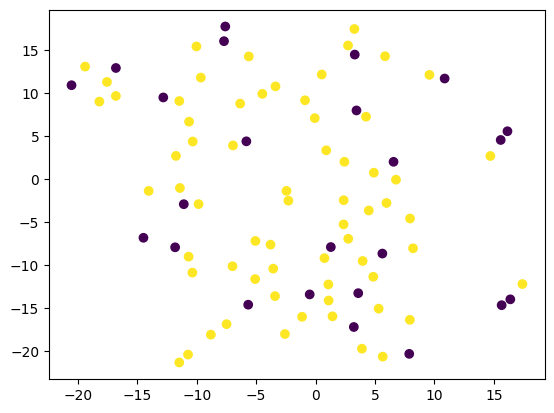

In [33]:
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=np.array(y))
plt.show()